In [ ]:
#!pip install requirements.txt


# After preparing the data, save it to a csv file to use in other models directly

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from data_augmentation import synonym_replacement, random_insertion, random_swap, random_deletion

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import naive_bayes, svm

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
import pickle
import nltk

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\halil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\halil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
human_data = load_dataset('kmkarakaya/turkishReviews-ds')
human_data = human_data['train'].to_pandas()
human_data.head()

Found cached dataset parquet (C:/Users/halil/.cache/huggingface/datasets/kmkarakaya___parquet/kmkarakaya--turkishReviews-ds-af8fd3a88d6e390a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

,review,review_length
0,Okan Üniversitesi Hastanesi'nde Çalışanların S...,45
1,Ekici Kaşar Peynirinin Peynir İle Alakası Yok....,49
2,Similac 2 Devam Sütunun İçinden Tahta Çıktı. ...,55
3,İlhan Duman Hukuk Bürosu Borç Mesajı Geliyor. ...,44
4,Samsung Kamera Flaş Sorunu. Alalı 1 gün oldu S...,40


In [3]:
# Some parts of this dataset is used for AI generated review production, so we need to filter out those
human_data = human_data.iloc[600:-300].reset_index(drop=True)
human_data.shape

(397872, 2)

In [4]:
human_data.columns

Index(['review', 'review_length'], dtype='object')

In [5]:
# All the reviews contain their titles as the first sentence. They can be removed to make the dataset more clean.
human_data['review'] = human_data['review'].apply(lambda x: re.sub(r'^.*\n', '', x))

# Update review lengths after removing titles
human_data['review_length'] = human_data['review'].apply(lambda x: len(x.split()))

human_data.head()

,review,review_length
0,"Bosch Bulaşık Makinesi Gelmiyor, 31.05.2020 ta...",43
1,Park Tv'de Tekrarlanan Filmler. Park Tv'deki f...,48
2,Grundig Servis Asla Gelmiyor. 15 05 2020 tarih...,52
3,Ziraat Sigorta Zorunlu Olmayan Poliçelerin Yen...,45
4,Vestel Ürünleri Maalesef Kötü Ve Değişim Yok. ...,35


In [6]:
ai_data = pd.read_excel('AI_Complaints.xlsx')
ai_data.head()

,text,model,instruction
0,Akbank Müşteri Hizmetleri ile yaşadığım deneyi...,GPT-4o,Akbank Müşteri Hizmetleri Hakkında
1,Cinemaximum’un vizyona sokulmayan filmler poli...,GPT-4o,Cinemaximum Vizyona Sokulmayan Filmler
2,Media Markt'tan birkaç saat önce verdiğim sipa...,GPT-4o,Media Markt Birkaç Saat Önce Verilen Siparişte...
3,Ulusal Elektronik’ten alışveriş yapmayı kesinl...,GPT-4o,Ulusal Elektronikten Uzak Durmalı.
4,Vanish Kosla kullanarak çıkarmak istediğim lek...,GPT-4o,Vanish Kosla Leke Yaptı


In [7]:
print("AI Data Shape: ", ai_data.shape)
print("Human Data Shape: ", human_data.shape)
print("Human Data:\n", human_data.describe())
print("Human Data Columns: ", human_data.columns)
print("Human Data Number of Words: ", human_data['review_length'].mean())
print("Human Data Maximum Number of Words: ", human_data['review_length'].max())
print("Human Data Minimum Number of Words: ", human_data['review_length'].min())

AI Data Shape:  (315, 3)
Human Data Shape:  (397872, 2)
Human Data:
        review_length
count  397872.000000
mean       46.002018
std         5.194693
min        29.000000
25%        43.000000
50%        46.000000
75%        49.000000
max       176.000000
Human Data Columns:  Index(['review', 'review_length'], dtype='object')
Human Data Number of Words:  46.00201823702095
Human Data Maximum Number of Words:  176
Human Data Minimum Number of Words:  29


In [8]:
# Human dataset
print("Human Data Shape: ", human_data.shape)
print("Human Data: ", human_data.describe())
print("Human Data Num of Words: ", human_data['review_length'].mean())

Human Data Shape:  (397872, 2)
Human Data:         review_length
count  397872.000000
mean       46.002018
std         5.194693
min        29.000000
25%        43.000000
50%        46.000000
75%        49.000000
max       176.000000
Human Data Num of Words:  46.00201823702095


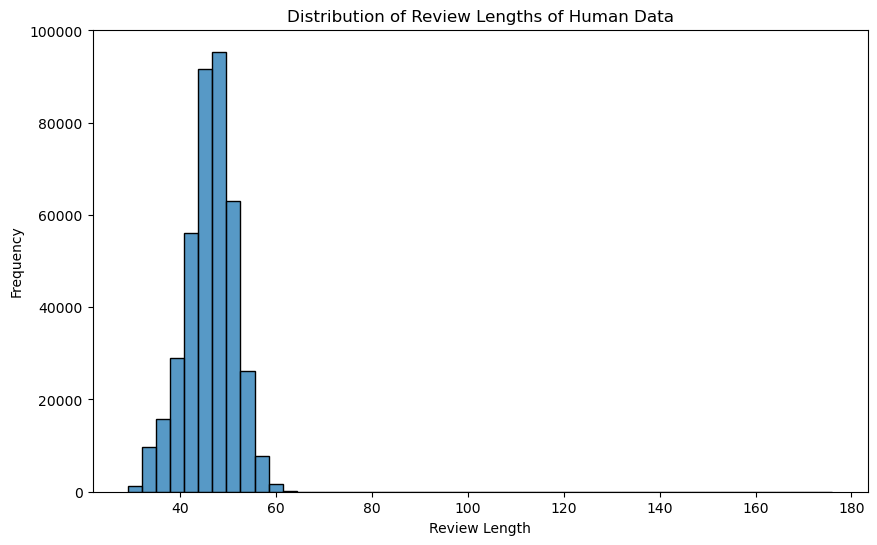

In [9]:
# Text Length Distribution for Human Data
plt.figure(figsize=(10, 6))
sns.histplot(human_data['review_length'], bins=50)
plt.title('Distribution of Review Lengths of Human Data')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

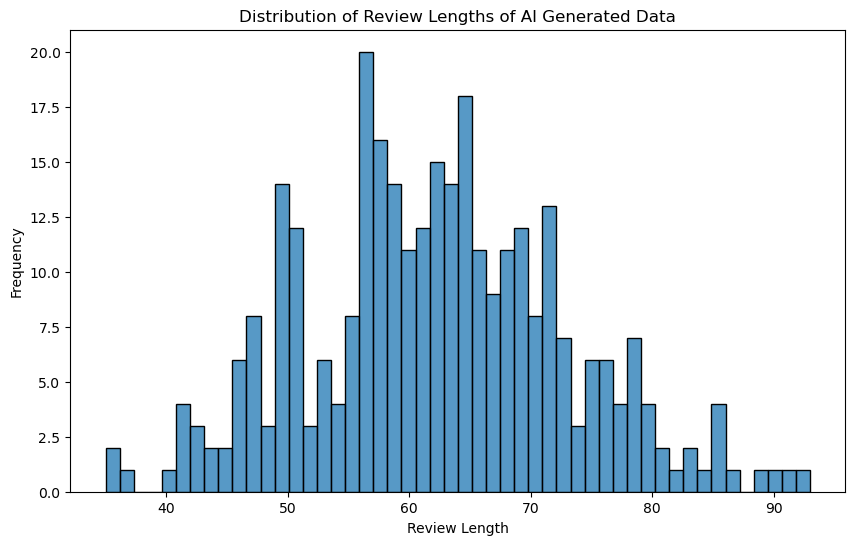

In [10]:
# Text Length Distribution for AI Data
ai_data['review_length'] = ai_data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(ai_data['review_length'], bins=50)
plt.title('Distribution of Review Lengths of AI Generated Data')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
human_data['label'] = 'human'
human_data['text'] = human_data['review']
ai_data['label'] = 'ai'
human_data = human_data[['text', 'label']]
ai_data = ai_data[['text', 'label']]


dataset = pd.concat([human_data, ai_data], ignore_index=True)
dataset.head()

,text,label
0,"Bosch Bulaşık Makinesi Gelmiyor, 31.05.2020 ta...",human
1,Park Tv'de Tekrarlanan Filmler. Park Tv'deki f...,human
2,Grundig Servis Asla Gelmiyor. 15 05 2020 tarih...,human
3,Ziraat Sigorta Zorunlu Olmayan Poliçelerin Yen...,human
4,Vestel Ürünleri Maalesef Kötü Ve Değişim Yok. ...,human


# Preprocess AI Generated Data

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from snowballstemmer import TurkishStemmer

# Stopwords listesi yükleniyor
nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# Kelime kökü bulucu
stemmer = TurkishStemmer()

def preprocess_text(text):
    # Küçük harfe çevirme
    text = text.lower()
    # Noktalama işaretlerini çıkarma
    text = re.sub(r'[^\w\s]', '', text)
    # Rakamları çıkarma
    text = re.sub(r'\d+', '', text)
    # Tokenleme
    words = word_tokenize(text)
    # Durdurma kelimelerini çıkarma ve stemming
    words = [stemmer.stemWord(word) for word in words if word not in turkish_stopwords]
    # Temizlenmiş metni birleştirme
    return ' '.join(words)

# AI veri setindeki metinleri ön işlemeden geçirme
ai_data['text'] = ai_data['text'].apply(preprocess_text)
print(ai_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\halil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                  text label
0    akbank müşter hizmet yaşadık de hayal kırıklık...    ai
1    cinemaxim vizyo sokulmaya film politikas cidi ...    ai
2    media markt saat ö verdik sipariş renk değişik...    ai
3    ulusal elektronik alışveriş yapma kesinlik tav...    ai
4    vanish kos kullanarak çıkarmak istedik lek köt...    ai
..                                                 ...   ...
310  cinemaxim y maxipar yüklemes yapamıyor dur ger...    ai
311  ziraat banka destek kredis başvuru bul sonuçla...    ai
312  denizli aras kargo çamlık şube ür bekletiliyor...    ai
313  iç kaşar peynir al ancak ür açtık iç gele gaz ...    ai
314  thyden bir uçuş coro sebep iptal edildik bilet...    ai

[315 rows x 2 columns]


In [13]:
sampling = human_data.iloc[0:3].reset_index(drop=True)
print(sampling['text'][0], "\n")
print(preprocess_text(sampling['text'][0]), "\n")
print(sampling['text'][1], "\n")
print(preprocess_text(sampling['text'][1]), "\n")
print(sampling['text'][2], "\n")
print(preprocess_text(sampling['text'][2]), "\n")

Bosch Bulaşık Makinesi Gelmiyor, 31.05.2020 tarihinde bulaşık makinesi aldık internet mağazasından hala ne gelen var ne giden ne arayan müşteri hizmetlerini arıyorum herhangi bir muhatap yok internet destek ekibine bildiriyoruz diyorlar kayıt oluşturuyorlar başka da bir şey yok. 1107017258 bulaşık makinesi sipariş numarası. 

bosch bulaşık makines gelmiyor tarih bulaşık makines al internet mağaza hal gele var gi araya müşter hizmet arıyor herhangi bir muhatap yok internet destek ekip bildiriyor diyor kayıt oluşturuyor başka bir yok bulaşık makines sipariş numaras 

Park Tv'de Tekrarlanan Filmler. Park Tv'deki filmleri ilgiyle izliyordum. Özellikle de korona sürecinde film izlemek en büyük hobim oldu. Ancak kanalınızda sürekli aynı filmler dönmeye başladı ve bu çok sık oluyor. Arşivinizde örneğin Western filmleri yok mu? Ya da film arşivinizi genişletemiyor musunuz? Çok can sıkıcı bir durum. 

park tvde tekrarlana film park tvdek film ilgi izliyor özellik koro süreç film izlemek büyük h

# Augmentation Function for AI Data

In [14]:
def augment_data(ai_data):
    # Split data into training and testing sets
    train_ai_df, test_ai_df = train_test_split(ai_data, test_size=0.3, random_state=42)
    
    # Augment training data
    augmented_texts = []
    for index, row in train_ai_df.iterrows():
        text = row['text']
        # Apply multiple transformations
        for _ in range(5):  # Repeat each transformation 5 times
            augmented_texts.append(synonym_replacement(text, n=2))
            augmented_texts.append(random_insertion(text, n=3))
            augmented_texts.append(random_swap(text, n=2))
            augmented_texts.append(random_deletion(text, p=0.1))

    train_ai_augmented = pd.DataFrame(augmented_texts, columns=['text'])
    train_ai_augmented['label'] = 'ai'

    # Augment test data
    augmented_texts = []
    for index, row in test_ai_df.iterrows():
        text = row['text']
        # Apply multiple transformations
        for _ in range(5):  # Repeat each transformation 5 times
            augmented_texts.append(synonym_replacement(text, n=2))
            augmented_texts.append(random_insertion(text, n=3))
            augmented_texts.append(random_swap(text, n=2))
            augmented_texts.append(random_deletion(text, p=0.1))

    test_ai_augmented = pd.DataFrame(augmented_texts, columns=['text'])
    test_ai_augmented['label'] = 'ai'

    return train_ai_augmented, test_ai_augmented


## TRAINING MODELS

In [16]:
# Initialize lists to store results
all_accuracies = {'LR': [], 'NB': [], 'SVM': []}
all_f1_scores = {'LR': [], 'NB': [], 'SVM': []}
all_conf_matrices = {'LR': [], 'NB': [], 'SVM': []}

# Loop to train and evaluate models
for i in range(10):
    # Augment AI data and sample human data
    train_ai_augmented, test_ai_augmented = augment_data(ai_data)
    num_of_samples = len(train_ai_augmented) + len(test_ai_augmented)
    sampled_human_data = human_data.sample(n=num_of_samples, random_state=i)
    
    # Preprocess sampled human data
    sampled_human_data['text'] = sampled_human_data['text'].apply(preprocess_text)
    train_human_df, test_human_df = train_test_split(sampled_human_data, test_size=0.3, random_state=i)
    
    # Combine and shuffle datasets
    combined_train_df = pd.concat([train_ai_augmented, train_human_df])
    combined_test_df = pd.concat([test_ai_augmented, test_human_df])

    # Encode labels
    Encoder = LabelEncoder()
    Train_Y = Encoder.fit_transform(combined_train_df['label'])
    Test_Y = Encoder.transform(combined_test_df['label'])

    # Vectorization
    Tfidf_vect = TfidfVectorizer(max_features=5000)
    Tfidf_vect.fit(pd.concat([ai_data['text'], human_data['text']]))  # Use full text data for fitting
    Train_X_Tfidf = Tfidf_vect.transform(combined_train_df['text'])
    Test_X_Tfidf = Tfidf_vect.transform(combined_test_df['text'])

    # Logistic Regression
    vectorizer = CountVectorizer(ngram_range=(1,3))
    X_train = vectorizer.fit_transform(combined_train_df['text'])
    X_test = vectorizer.transform(combined_test_df['text'])

    log_reg = LogisticRegression()
    log_reg.fit(X_train, Train_Y)

    predictions_LR = log_reg.predict(X_test)
    acc_lr = round(accuracy_score(predictions_LR, Test_Y), 4)
    f1_lr = round(f1_score(Test_Y, predictions_LR, average='weighted'), 4)
    all_accuracies['LR'].append(acc_lr)
    all_f1_scores['LR'].append(f1_lr)
    all_conf_matrices['LR'].append(confusion_matrix(Test_Y, predictions_LR))

    # Naive Bayes
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(Train_X_Tfidf, Train_Y)
    predictions_NB = Naive.predict(Test_X_Tfidf)
    acc_naive = round(accuracy_score(predictions_NB, Test_Y), 4)
    f1_naive = round(f1_score(Test_Y, predictions_NB, average='weighted'), 4)
    all_accuracies['NB'].append(acc_naive)
    all_f1_scores['NB'].append(f1_naive)
    all_conf_matrices['NB'].append(confusion_matrix(Test_Y, predictions_NB))

    # SVM
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(Train_X_Tfidf, Train_Y)
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    acc_svm = round(accuracy_score(predictions_SVM, Test_Y), 4)
    f1_svm = round(f1_score(Test_Y, predictions_SVM, average='weighted'), 4)
    all_accuracies['SVM'].append(acc_svm)
    all_f1_scores['SVM'].append(f1_svm)
    all_conf_matrices['SVM'].append(confusion_matrix(Test_Y, predictions_SVM))
    print(f"{i+1}. Iteration -> LR Acc: {acc_lr}, LR F1: {f1_lr}, NB Acc: {acc_naive}, NB F1: {f1_naive}, SVM Acc: {acc_svm}, SVM F1: {f1_svm}")

# Final results
print("Logistic Regression - Average Accuracy:", round(np.mean(all_accuracies['LR']), 4))
print("Logistic Regression - Average F1 Score:", round(np.mean(all_f1_scores['LR']), 4))
print("Naive Bayes - Average Accuracy:", round(np.mean(all_accuracies['NB']), 4))
print("Naive Bayes - Average F1 Score:", round(np.mean(all_f1_scores['NB']), 4))
print("SVM - Average Accuracy:", round(np.mean(all_accuracies['SVM']), 4))
print("SVM - Average F1 Score:", round(np.mean(all_f1_scores['SVM']), 4))

1. Iteration -> LR Acc: 0.9586, LR F1: 0.9585, NB Acc: 0.9723, NB F1: 0.9723, SVM Acc: 0.9356, SVM F1: 0.9354
2. Iteration -> LR Acc: 0.9515, LR F1: 0.9513, NB Acc: 0.9739, NB F1: 0.9739, SVM Acc: 0.938, SVM F1: 0.9378
3. Iteration -> LR Acc: 0.9612, LR F1: 0.9612, NB Acc: 0.9763, NB F1: 0.9763, SVM Acc: 0.9528, SVM F1: 0.9527
4. Iteration -> LR Acc: 0.9541, LR F1: 0.954, NB Acc: 0.977, NB F1: 0.977, SVM Acc: 0.9573, SVM F1: 0.9572
5. Iteration -> LR Acc: 0.9544, LR F1: 0.9543, NB Acc: 0.9755, NB F1: 0.9755, SVM Acc: 0.9427, SVM F1: 0.9426
6. Iteration -> LR Acc: 0.9541, LR F1: 0.954, NB Acc: 0.9718, NB F1: 0.9718, SVM Acc: 0.9499, SVM F1: 0.9498
7. Iteration -> LR Acc: 0.953, LR F1: 0.9529, NB Acc: 0.9752, NB F1: 0.9752, SVM Acc: 0.9459, SVM F1: 0.9458
8. Iteration -> LR Acc: 0.9541, LR F1: 0.954, NB Acc: 0.9728, NB F1: 0.9728, SVM Acc: 0.9517, SVM F1: 0.9516
9. Iteration -> LR Acc: 0.9493, LR F1: 0.9492, NB Acc: 0.9731, NB F1: 0.9731, SVM Acc: 0.9435, SVM F1: 0.9434
10. Iteration -> 

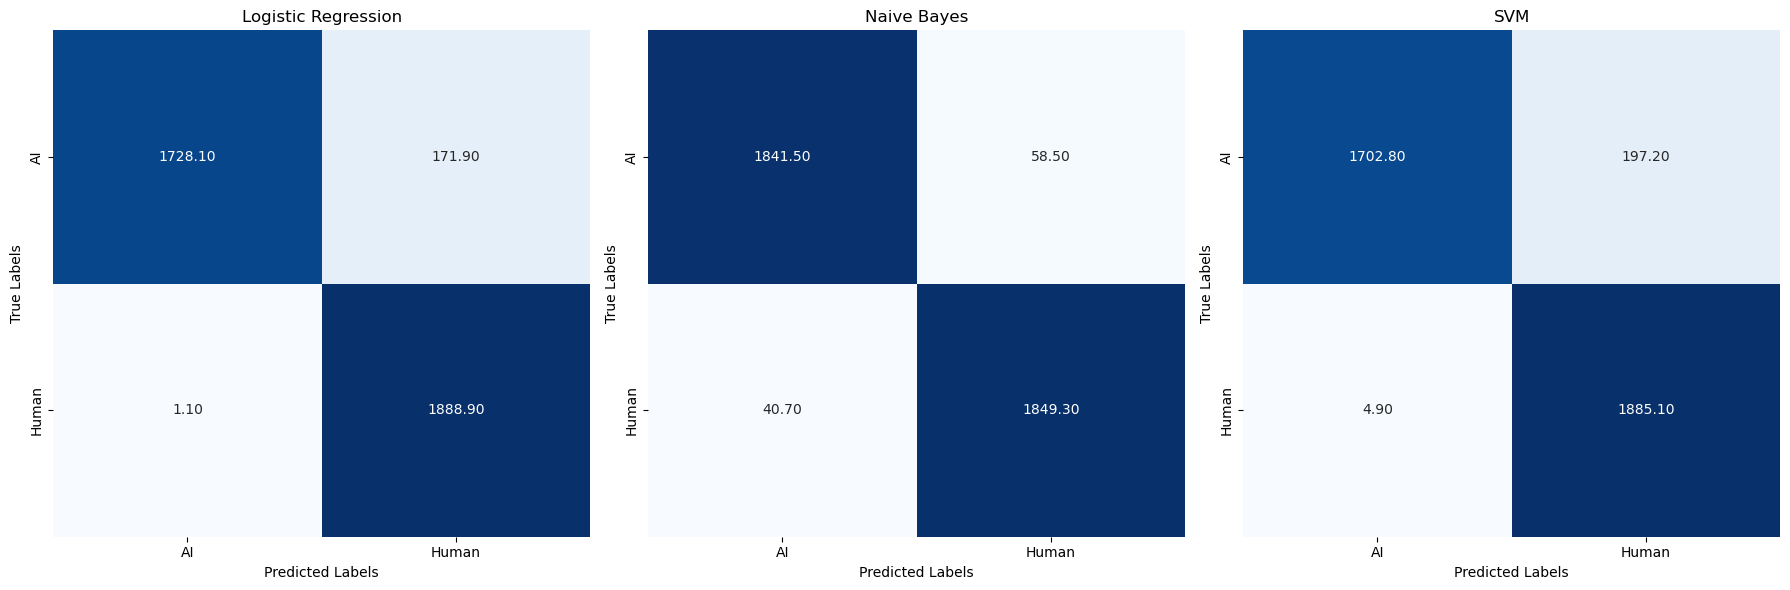

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to calculate the mean of confusion matrices
def mean_confusion_matrix(conf_matrices):
    sum_matrix = np.zeros_like(conf_matrices[0])
    for matrix in conf_matrices:
        sum_matrix += matrix
    return sum_matrix / len(conf_matrices)

# Calculate mean confusion matrices for each model
mean_cm_LR = mean_confusion_matrix(all_conf_matrices['LR'])
mean_cm_NB = mean_confusion_matrix(all_conf_matrices['NB'])
mean_cm_SVM = mean_confusion_matrix(all_conf_matrices['SVM'])

# Plotting function
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['AI', 'Human'])
    ax.set_yticklabels(['AI', 'Human'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_confusion_matrix(mean_cm_LR, 'Logistic Regression', axes[0])
plot_confusion_matrix(mean_cm_NB, 'Naive Bayes', axes[1])
plot_confusion_matrix(mean_cm_SVM, 'SVM', axes[2])
plt.tight_layout()
plt.show()


# The model seem to work too good. Let's see the results with cross validation

Cross-Validation Average Accuracy: 0.9995459704880817
Test Set Accuracy: 0.9559366754617414
Classification Report on Test Set:
               precision    recall  f1-score   support

          ai       1.00      0.91      0.95      1900
       human       0.92      1.00      0.96      1890

    accuracy                           0.96      3790
   macro avg       0.96      0.96      0.96      3790
weighted avg       0.96      0.96      0.96      3790



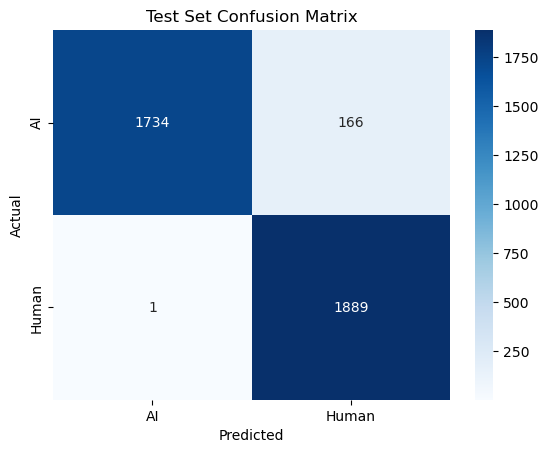

In [21]:
# Split data into training and testing sets
vectorizer = CountVectorizer(ngram_range=(1,3))
X_train = vectorizer.fit_transform(combined_train_df['text'])
X_test = vectorizer.transform(combined_test_df['text'])

y_train = combined_train_df['label'].values
y_test = combined_test_df['label'].values

# Initialize KFold for the training set only
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Lists to store results for each fold
accuracies = []
class_reports = []
conf_matrices = []

# Perform cross-validation on the training data only
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model on the fold
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    predictions = model.predict(X_val_fold)
    
    # Metrics calculation
    accuracies.append(accuracy_score(y_val_fold, predictions))
    class_reports.append(classification_report(y_val_fold, predictions, output_dict=True))
    conf_matrices.append(confusion_matrix(y_val_fold, predictions))

# Evaluate the final model on the test set
final_predictions = model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)
final_class_report = classification_report(y_test, final_predictions)
final_conf_matrix = confusion_matrix(y_test, final_predictions)

# Display results
print("Cross-Validation Average Accuracy:", np.mean(accuracies))
print("Test Set Accuracy:", final_accuracy)
print("Classification Report on Test Set:\n", final_class_report)

# Display confusion matrix for the test set
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Test Set Confusion Matrix')
plt.show()